# Graded Assignment 2 - Air Quality and Weather in the Netherlands


# Introduction to This Template Notebook

* This is a **group** notebook.
* Make sure you work in a **copy** of `...-template.ipynb`,
**renamed** to `...-yourIDnrs.ipynb`,
where `yourIDnrs` is the TU/e identification numbers of the members of the group.

<div class="alert alert-danger" role="danger">
<h3>Integrity</h3>
<ul>
    <li>In this course you must act according to the rules of the TU/e code of scientific conduct.</li>
    <li>This exercise or graded assignment is to be executed by the members of the group independently from other people.</li>
    <li>You must not copy from the Internet, your friends, books... If you represent other people's work as your own, then that constitutes fraud and will be reported to the Examination Committee.</li>
    <li>Making your work available to others (complicity) also constitutes fraud.</li>
</ul>
</div>

You are expected to work with Python code and Markdown in this notebook.

Proceed in this notebook as follows:
* **Read** the assignment (separate PDF).
* **Write** your decisions/solutions/interpretations in the appropriate sections.
  * For this you can use both Code and Markdown cells. Information about how to use these cells is available in the _Getting Started_ assignment.
* **Run** _all_ code cells (also the ones _without_ your code),
    _in linear order_ from the first code cell.

**Personalize your notebook**:
1. Copy the following line of code:

  ```python
  AUTHOR_ID_NRS = ['1234567', '2234567', '3234567', '4234567']
  ```
1. Paste them between the marker lines in the next code cell.
1. Fill in the _identification numbers_ of all members of the group as a list of strings between the `Author` markers.
1. Run the code cell by putting the cursor there and typing **Control-Enter**.


In [1]:
#// BEGIN_TODO [Author] Name, Id.nr., Date, as strings (1 point)

AUTHOR_ID_NRS = ['2047810', '2234567', '3234567', '4234567', '1998633']

#// END_TODO [Author]

## Table of Contents

- [Preparation](#Preparation)
    - [Load the libraries](#Load-the-libraries)
- [Part 1a. Hypothesis selection](#Part-1a:-Hypothesis-selection)
- [Part 1b. Hypothesis refinement](#Part-1b:-Hypothesis-refinement)
- [Part 2. Queries and data cleaning](#Part-2:-Queries-and-data-cleaning)
- [Part 3. Hypothesis testing and interpretation](#Part-3.-Hypothesis-testing-and-interpretation)
- [Part 4. Pitching results](#Part-4.-Pitching-results)

## Preparation
### Load the libraries

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression         # for linear regression
from sklearn.cluster import KMeans                        # for clustering
from sklearn.tree import DecisionTreeClassifier           # for decision tree mining
from sklearn.metrics import mean_absolute_error, confusion_matrix
from sklearn.model_selection import train_test_split
from treeviz import tree_print                            # to print decision tree

import scipy.stats as stats                               # to compute z-scores
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import sqlite3                                            # to interact with the database
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline                                 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns                                     # also improves the look of plots
sns.set()
plt.rcParams['figure.figsize'] = 10, 5                    # default hor./vert. size of plots, in inches
plt.rcParams['lines.markeredgewidth'] = 1                 # to fix issue with seaborn box plots; needed after import seaborn

## Part 1a: Hypothesis selection

After comparing our GA1 posters, three hypotheses stood out, that could be a good basis for our refined hypothesis:

- 1: 'O3 levels rise due to weather factors that increase in the summer.'

We noticed that Ozone (O3) follows a seasonal pattern and increases in concentration during summer. This raised our curiosity to see what summer related components affect the concentration of this compound, for instance, humidity, temperature and duration of sunlight.
However, the most interesting part is the connection between humidity and temperature. This is because the concentration increases when the temperature increases. However, when the temperature increases, the humidity increases, and after some research, we learned that an increase in humidity can lead to a decrease in the concentration of Ozone. Since we are very interested in this correlation, we decided to approve this hypothesis.

- 2: 'Pm_10 levels are affected by rainfall, wind speed, and temperature.'

The second hypothesis could be interesting since, rainfall may reduce PM_10 by cleansing the atmosphere, windspeed might disperse particles, and temperature could influence chemical reactions related to PM_10. We anticipate a negative correlation between rainfall and PM_10 levels, as rain cleanses the air. Similarly, we expect a negative correlation with windspeed, as it disperses particles. However, we have no expectation for the relation with temperature.

- 3:'There is a negative correlation between the temperature and the concentration of compound no.'

When the concentration of the compound Nitrogen Monoxide (NO) is compared with the temperature it shows that when the temperature increases, the concentration decreases, and since this can be quite useful for looking at emissions during winter compared to summer, it can be helpful to use this information for a more calculated use of NO emitting substances, to reduce emissions. We expect that when temperature increases, this will lead to a decrease in concentration. 

As mentioned in the first hypothesis, we have decided to continue our research into the hypothesis:'O3 levels rise due to weather factors that increase in the summer (humidity, temperature, sunlight duration).', since we are very interested in the correlation between humidity, temperature and concentration.

## Part 1b: Hypothesis refinement

Our original hypothesis, was 'O3 levels rise due to weather factors that increase in the summer'

O3 Levels
- What is Ozone?
- What does Ozone do?
- How is it measured?
- Which units are used for the measurement
- What is considered an increase or rise in levels?

Weather Factors
- What factors can have an influence on O3 levels?
- How is the data collected?
- What has an effect on weather factors?

Weather Factors that increase in the summer
- Which weather factors have an influence on O3 and increase during the summer?
- Which months are considered summer?
 
After our review of our original hypotheses we concluded that the use of three different weather factors, puts too many variables in our equation, since it will be very difficult to find a correlation between all three. Thus, we have decided to look at only the effect of temperature and humidity on the concentration of Ozone. However, we also realised that the location has an impact on the weather factors. A coastal area normally increases humidity, but regulates the temperature, making it more stable. Therefore, we have chosen to put our focus on the differences between the coastal area and an inland region. Therefore we have chosen weather and air quality stations near the sea, and near each other so that weather related differences are minimized.
 
This led to our refined hyopthesis: 'In coastal areas, the levels of ozone (O3) exhibit smaller fluctuation compared to inland areas due to the influence of temperature and humidity.'

## Part 2: Queries and data cleaning

In [3]:
# (Julian Luijke)
# Path and connect to the database in the files (doesnt need to be repeated in code again)
cnx = sqlite3.connect("datasets/aqw.db")

# Name all the weather factors needed (doesnt need to be repeated in code again), remove some of these if it is one that's not needed
WEATHER_FACTORS = ['wind_direction', 'wind_speed', 'wind_gust', 'temperature', 
                  'sunshine_duration', 'global_radiation', 'precipitation', 
                  'air_pressure', 'visibility', 'cloud_cover', 'humidity', 
                  'fog', 'rainfall', 'snow', 'thunder', 'ice_formation']

# Get all the info for the dataframe of the air quality station using the code
# The dataframe for the one near the sea
QUERY_AQ_SEA = f"""
    SELECT datetime, {', '.join(("o_3", "pm_10"))} 
    FROM air_quality_data 
    WHERE station_code='{"NL10318"}'
"""

# The dataframe for the one more landinward
QUERY_AQ_LAND = f"""
    SELECT datetime, {', '.join(("o_3", "pm_10"))} 
    FROM air_quality_data 
    WHERE station_code='{"NL10133"}'
"""
# Get O3 and pm_10 info of the air quality station in a dataframe
# Sea one
df_aq_sea = pd.read_sql_query(QUERY_AQ_SEA, cnx, index_col='datetime', parse_dates=['datetime'])

# Land one
df_aq_land = pd.read_sql_query(QUERY_AQ_LAND, cnx, index_col='datetime', parse_dates=['datetime'])

# Get all the info about the weather factor ready to put in a dataframe using the code of the chosen weather station
QUERY_WEATHER_SEA = f"""
    SELECT datetime, {', '.join(WEATHER_FACTORS)} 
    FROM weather_data 
    WHERE station_code={"310"}
"""

QUERY_WEATHER_LAND = f"""
    SELECT datetime, {', '.join(WEATHER_FACTORS)} 
    FROM weather_data 
    WHERE station_code={"380"}
"""

# Get weather data of the weather station chosen in a dataframe
df_weather_sea = pd.read_sql_query(QUERY_WEATHER_SEA, cnx, 
                               index_col='datetime', 
                               parse_dates=['datetime'])

df_weather_land = pd.read_sql_query(QUERY_WEATHER_LAND, cnx, 
                               index_col='datetime', 
                               parse_dates=['datetime'])

# Close database connection
cnx.close()

# Make both dataframes (of the weather and compound levels of each station + close weather station) be in the same one
df_data_sea = df_aq_sea.join(df_weather_sea, how='outer')
df_data_land = df_aq_land.join(df_weather_land, how='outer')

# To show either one of the dataframes in case needed: remove the # from either one of them
#df_data_sea
#df_data_land

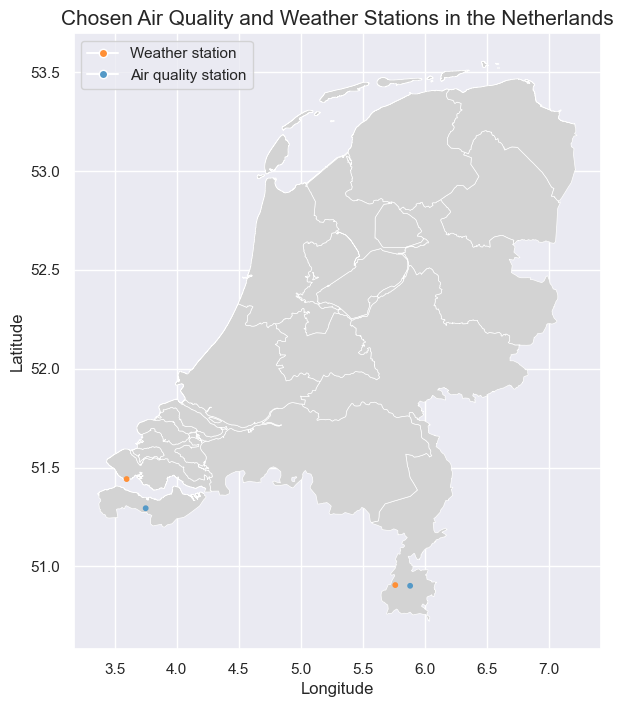

In [4]:
# (Nahid Kassam)

# Import required librairies for generating map
from matplotlib.lines import Line2D
from shapely.geometry import Point
import geopandas as gpd

# Defines a function that generates a map of the Netherlands and ads colored markers for given specified locations
def plot_stations_on_map(df_stations):
    
# Define a variable to retrieve the map shape from a given path
    map_nl = gpd.read_file('./datasets/stanford-st293bj4601-shapefile.zip')
    
    gdf = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in zip(df_stations['longitude'], df_stations['latitude'])])
    gdf['color'] = list(df_stations['color'])
    gdf.crs = map_nl.crs

# Define subplots to add information to the map
    f, ax = plt.subplots(1, figsize=(8, 8))

    map_nl.plot(linewidth=0.5, edgecolor='white', color='lightgrey',legend=True, ax=ax)
    gdf.plot(ax=ax, marker='o', color=gdf['color'], markersize=10)

# Define the title, xlabel and ylabel of our map/graph
    ax.set_title('Chosen Air Quality and Weather Stations in the Netherlands', size=15)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# Define the legend and its components
    legend = [
        Line2D([0], [0], markerfacecolor='#FF8F35', marker='o', color='w', label='Weather station'),
        Line2D([0], [0], markerfacecolor='#5499C7', marker='o', color='w', label='Air quality station')
    ]
    ax.legend(handles=legend, loc='upper left')
    return ax

# Define a new function that retrieves Latitude and Longitude data from the given database
def all_stations():
    aqs_sql = "SELECT name, latitude, longitude FROM air_quality_stations WHERE code = 'NL10318' OR code = 'NL10133'"
    ws_sql = "SELECT name, latitude, longitude FROM weather_stations WHERE code = 380 OR code = 310"
    with sqlite3.connect('./datasets/aqw.db') as conn:
        df_aqs = pd.read_sql_query(aqs_sql, conn)
        df_ws = pd.read_sql_query(ws_sql, conn)
    df_aqs['color'] = "#5499c7"
    df_ws['color'] = "#ff8f35"
    return pd.concat([df_ws, df_aqs])

# Plot the mop
plot_stations_on_map(all_stations());

In [5]:
# (Nahid Kassam)
# Data cleaning tbd

"""
delete the other data columns we dont need
choose the exact time period we want to look into
Compute summary statistics （line plot）and pick out the outlyiers（boxplot
Compute and compare z-scores
"""

'\ndelete the other data columns we dont need\nchoose the exact time period we want to look into\nCompute summary statistics （line plot）and pick out the outlyiers（boxplot\nCompute and compare\xa0z-scores\n'

## Part 3. Hypothesis testing and interpretation

In [6]:
# Use this cell as you like, and add more cells as needed.

## Part 4. Polishing and pitching results

In [7]:
# This section is only for generating figures if you need it. You may leave it empty.

# Feedback

Please fill in this questionaire to help us improve this course for the next year. Your feedback will be anonymized and will not affect your grade in any way!

### How many hours did you spend on these exercises?

Assign a number to `feedback_time`.

In [8]:
#// BEGIN_FEEDBACK [Feedback_1] (0 point)
feedback_time = 10
#// END_FEEDBACK [Feedback_1] (0 point)

import numbers

assert isinstance(feedback_time, numbers.Number), "Please assign a number to feedback_time"
print(feedback_time)

10


### How difficult did you find these exercises?

Assign an integer to `feedback_difficulty`, on a scale 0 - 10, with 0 being very easy, 5 being just right, and 10 being very difficult.

In [9]:
#// BEGIN_FEEDBACK [Feedback_2] (0 point)
feedback_difficulty = 7
#// END_FEEDBACK [Feedback_2] (0 point)

import numbers

assert isinstance(feedback_difficulty, numbers.Number), "Please assign a number to feedback_difficulty"
print(feedback_difficulty)

7


### (Optional) What did you like?

Assign a string to `feedback_like`.

In [10]:
#// BEGIN_FEEDBACK [Feedback_3] (0 point)

#// END_FEEDBACK [Feedback_3] (0 point)

### (Optional) What can be improved?

Assign a string to `feedback_improve`. Please be specific, so that we can act on your feedback. For example, mention the specific exercises and what was unclear.

In [11]:
#// BEGIN_FEEDBACK [Feedback_4] (0 point)

#// END_FEEDBACK [Feedback_4] (0 point)




## How to Submit Your Work

1. **Before submitting**, you must run your notebook by doing **Kernel > Restart & Run All**.  
   Make sure that your notebook runs without errors **in linear order**.
1. Remember to rename the notebook as explained at the beginning of this notebook.
1. Submit the executed notebook with your work
   for the appropriate assignment in **Canvas**.
1. In the **Momotor** tab in Canvas,
  you can select that assignment again to find some feedback on your submitted work.
  If there are any problems reported by _Momotor_,
  then you need to fix those,
  and **resubmit the fixed notebook**.

In case of a high workload on our server
(because many students submit close to the deadline),
it may take longer to receive the feedback.




---

In [12]:
# List all defined names
%whos

Variable                 Type          Data/Info
------------------------------------------------
AUTHOR_ID_NRS            list          n=5
DecisionTreeClassifier   ABCMeta       <class 'sklearn.tree._cla<...>.DecisionTreeClassifier'>
ECDF                     type          <class 'statsmodels.distr<...>rical_distribution.ECDF'>
KMeans                   type          <class 'sklearn.cluster._kmeans.KMeans'>
Line2D                   type          <class 'matplotlib.lines.Line2D'>
LinearRegression         ABCMeta       <class 'sklearn.linear_mo<...>._base.LinearRegression'>
Point                    type          <class 'shapely.geometry.point.Point'>
QUERY_AQ_LAND            str           \n    SELECT datetime, o_<...> station_code='NL10133'\n
QUERY_AQ_SEA             str           \n    SELECT datetime, o_<...> station_code='NL10318'\n
QUERY_WEATHER_LAND       str           \n    SELECT datetime, wi<...> WHERE station_code=380\n
QUERY_WEATHER_SEA        str           \n    SELECT dateti

---

# (End of Notebook) <span class="tocSkip"></span>

&copy; 2017-2023 - **TU/e** - Eindhoven University of Technology